In [1]:
!nvidia-smi

Sat Apr  5 15:06:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 83.1MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 136MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 54.8ms
Speed: 12.3ms preprocess, 54.8ms inference, 392.2ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

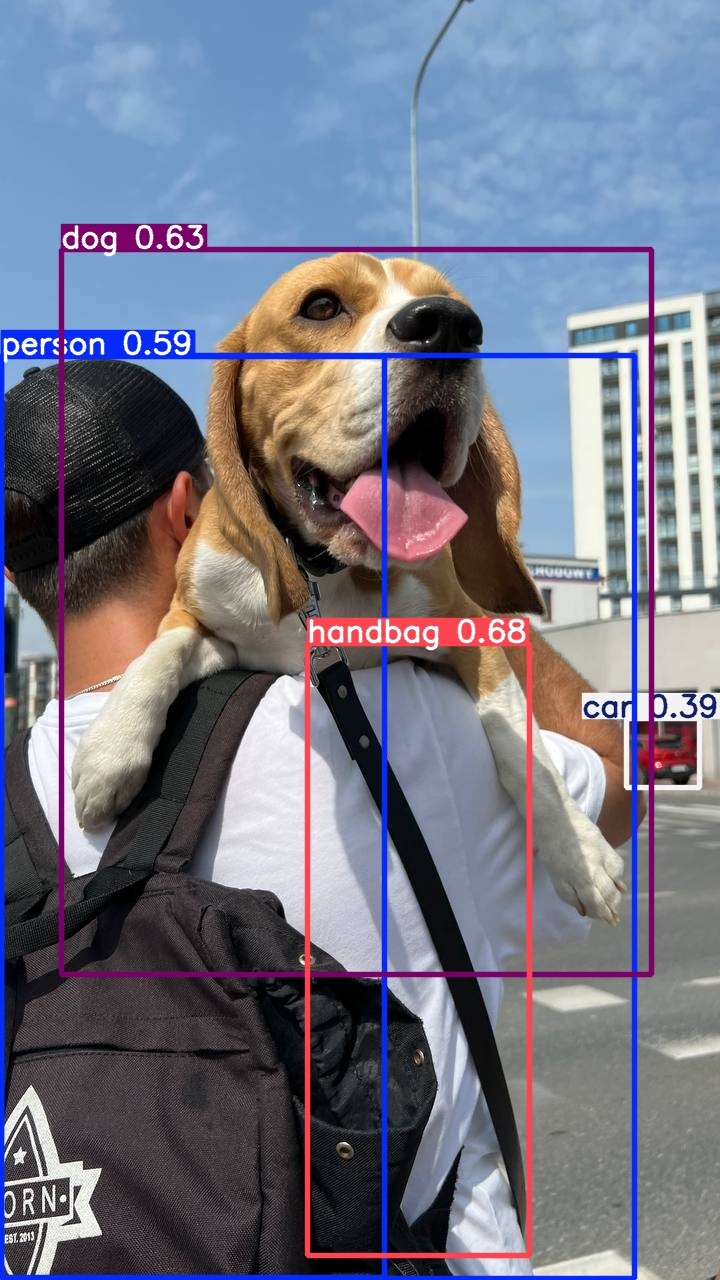

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [8]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 56.2ms
Speed: 3.5ms preprocess, 56.2ms inference, 145.5ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [9]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [10]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [11]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [12]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

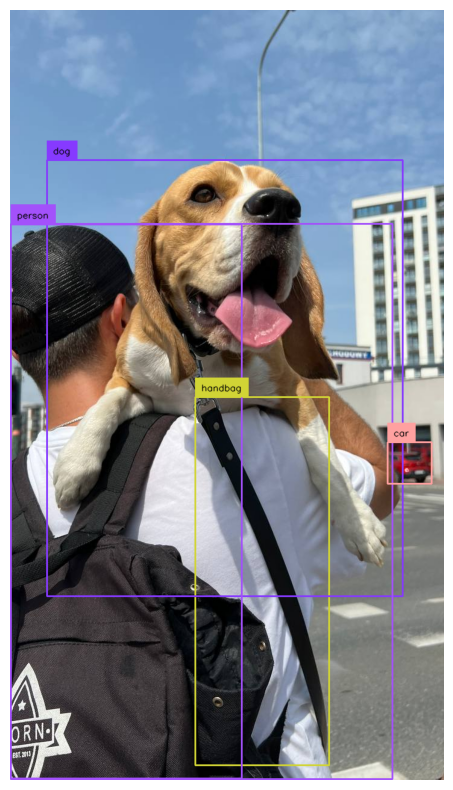

In [13]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [14]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets



from roboflow import Roboflow
rf = Roboflow(api_key="4sM9VYzQBsOefDzOIa6H")
project = rf.workspace("kuivashev").project("my-normal-dataset")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to my-normal-dataset-1 in yolov11:: 100%|██████████| 36362/36362 [00:10<00:00, 3308.70it/s]


## Custom Training

In [15]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 133MB/s] 
New https://pypi.org/project/ultralytics/8.3.102 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/my-normal-dataset-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [16]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1743865896.ea0ea431c07b.1961.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


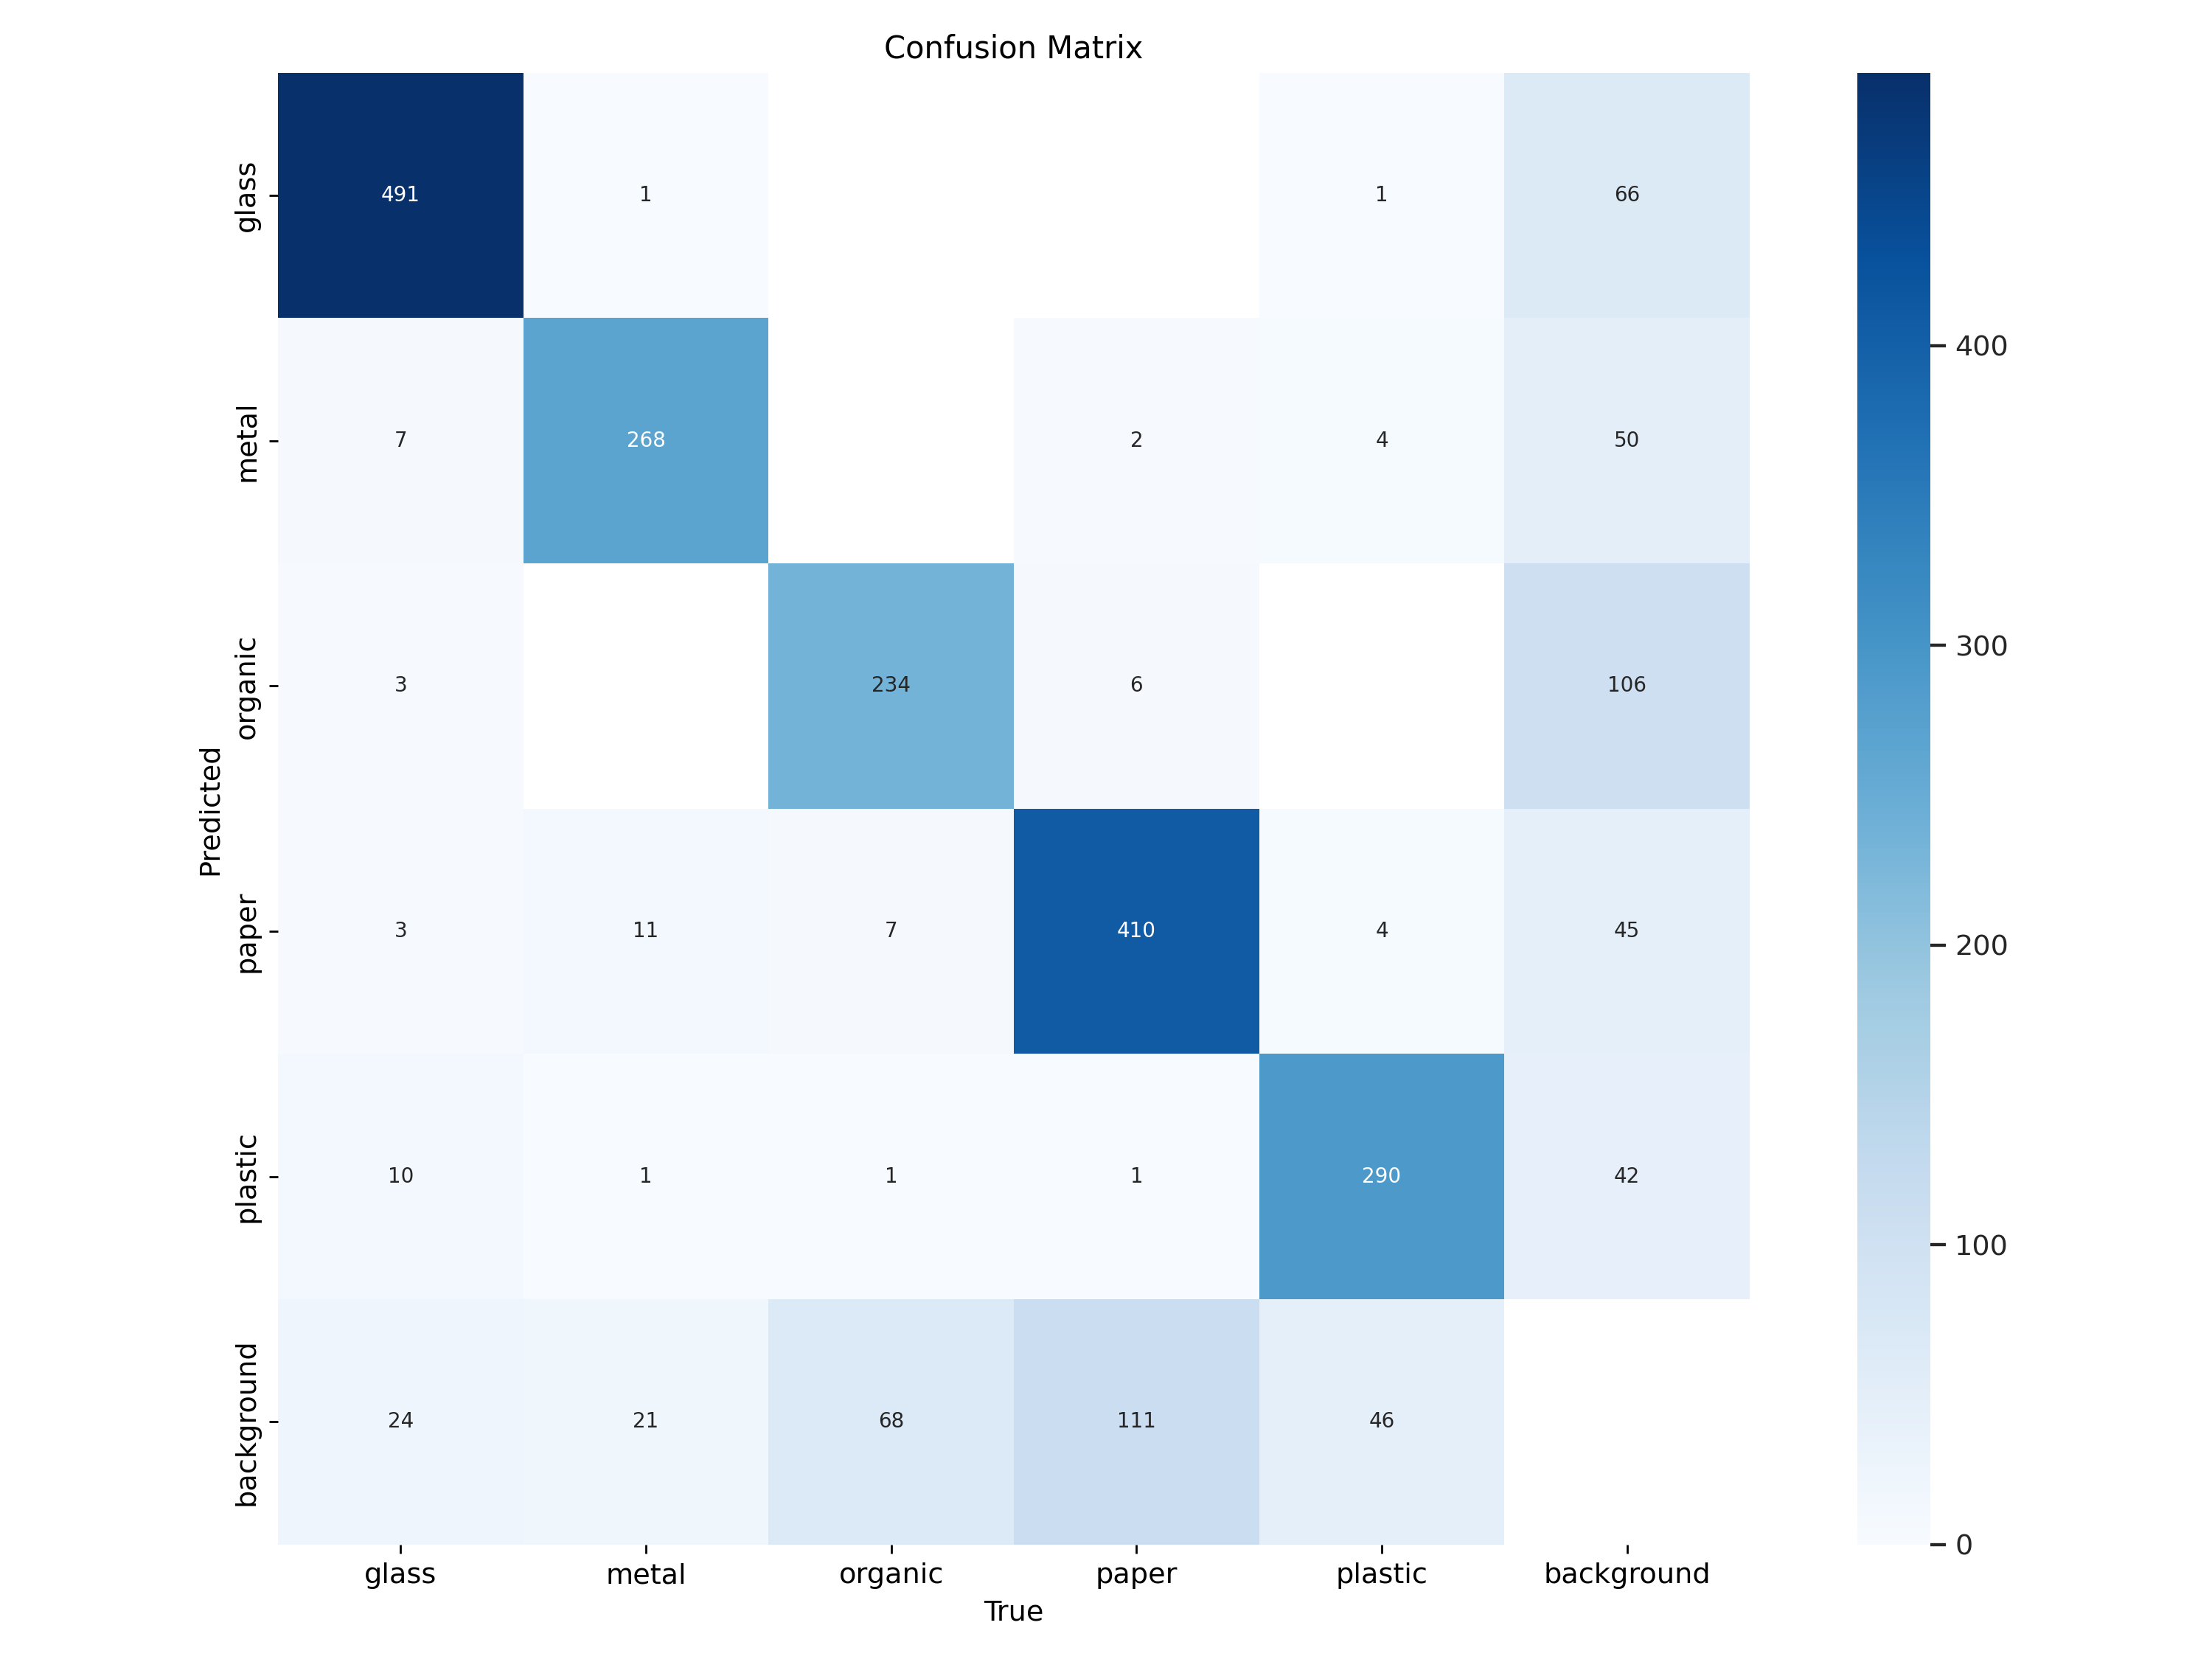

In [17]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

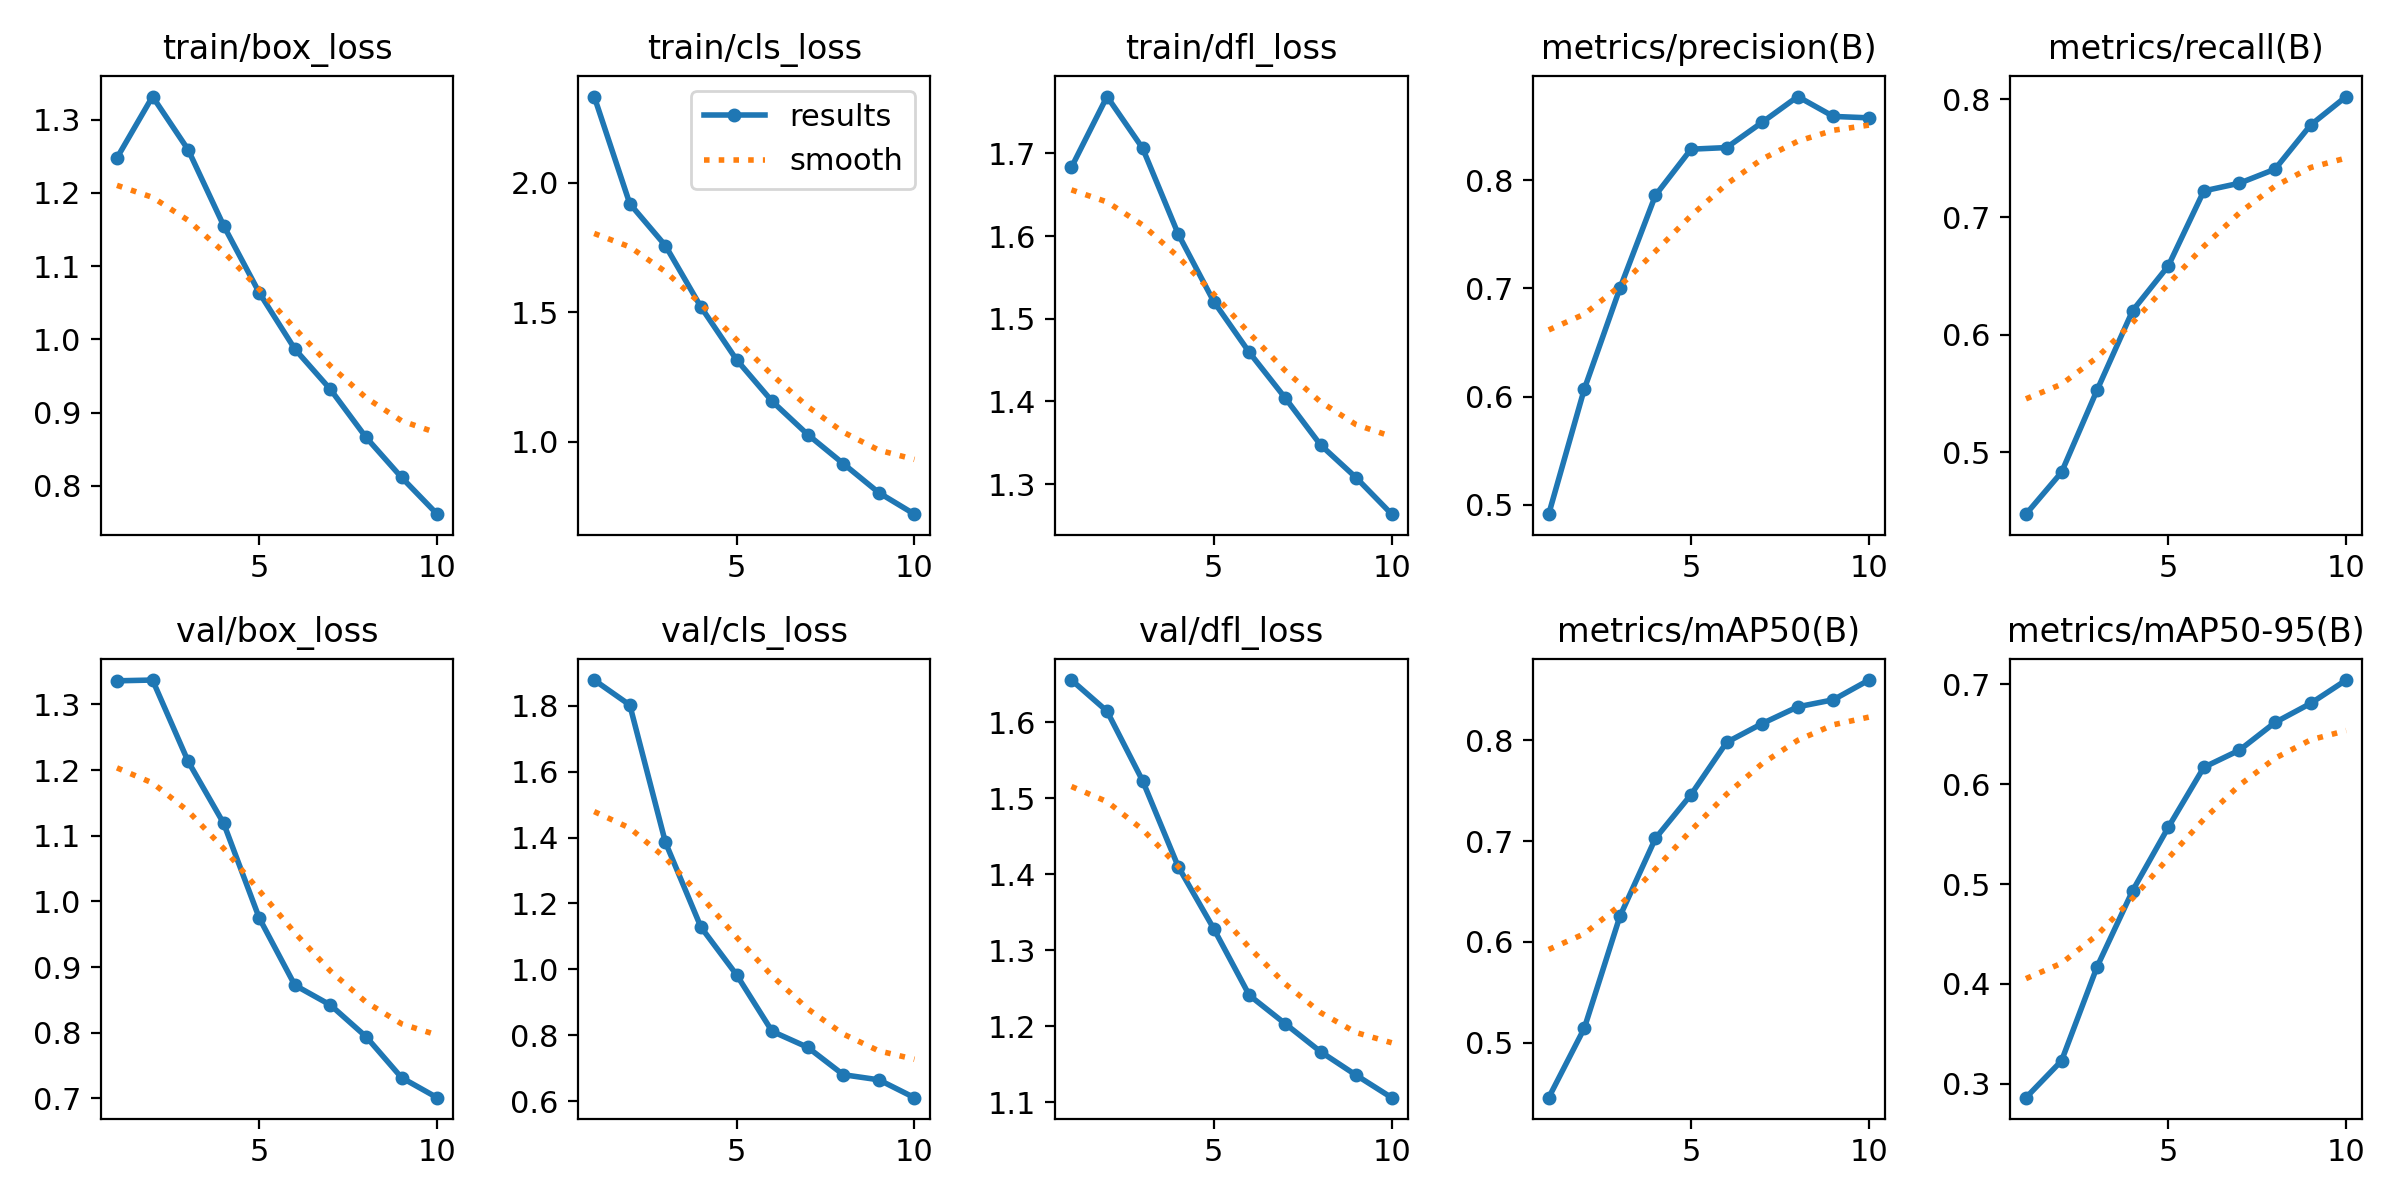

In [18]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

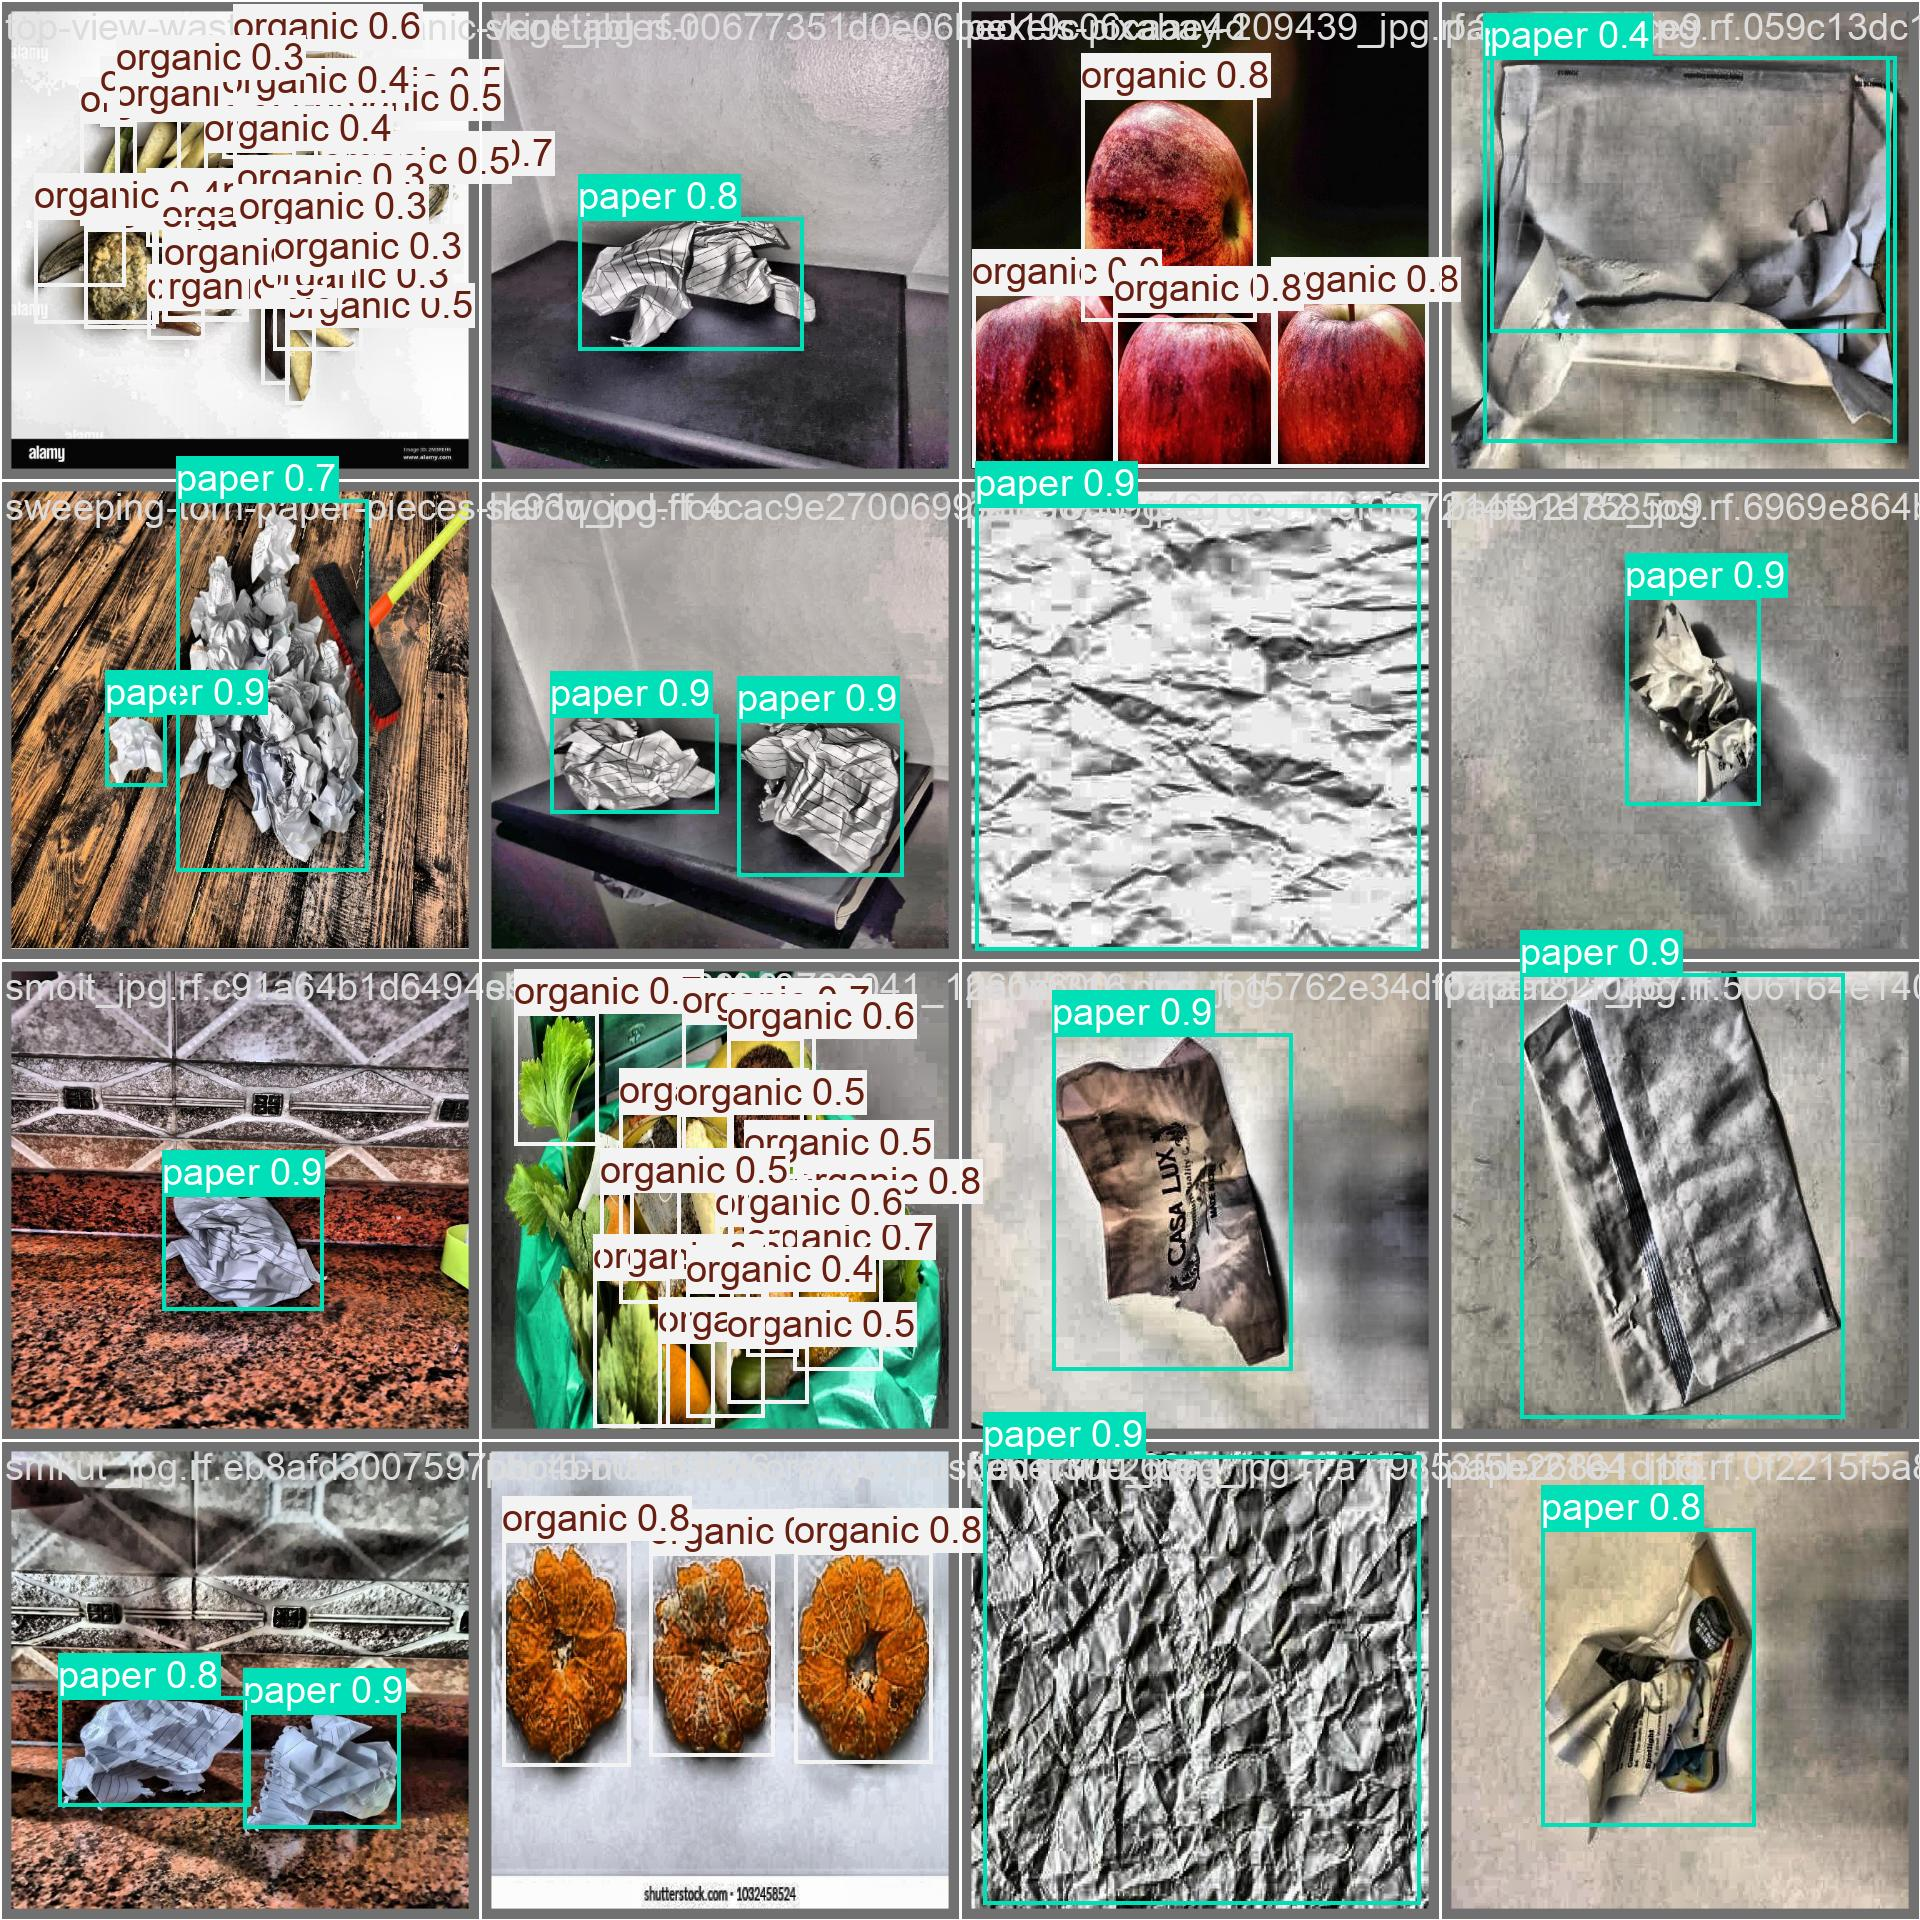

In [31]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

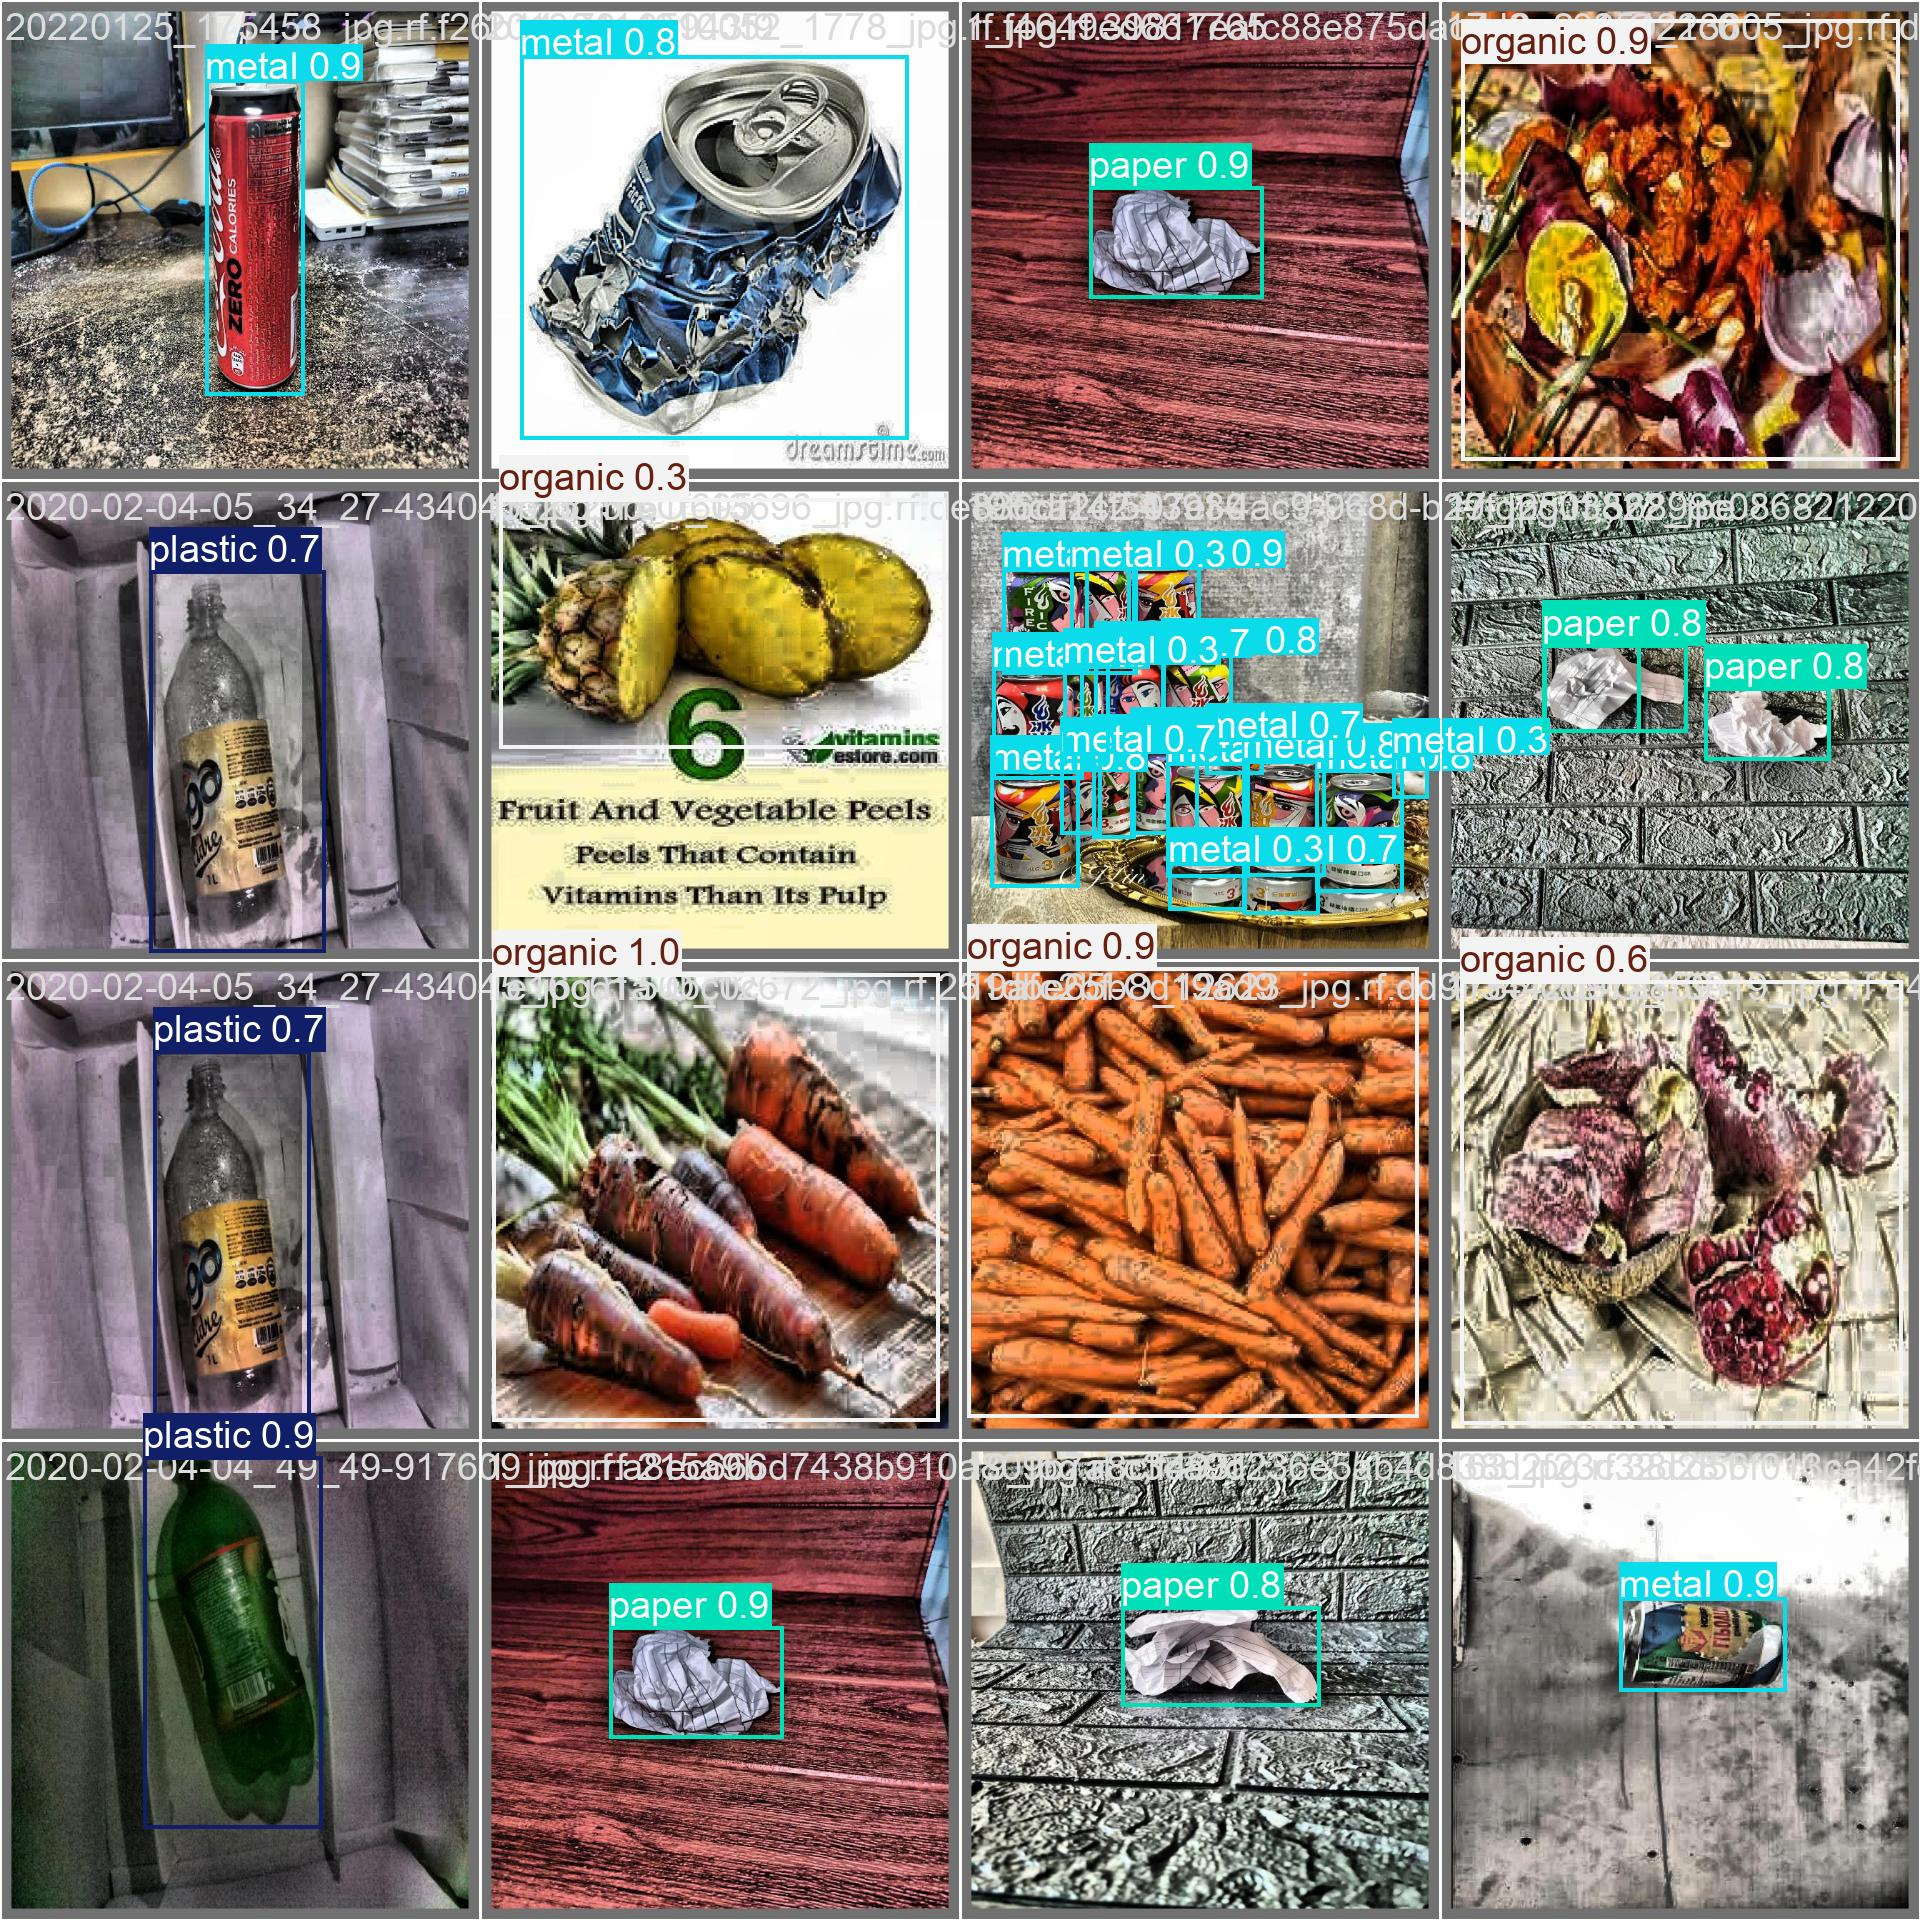

In [32]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch1_pred.jpg', width=600)

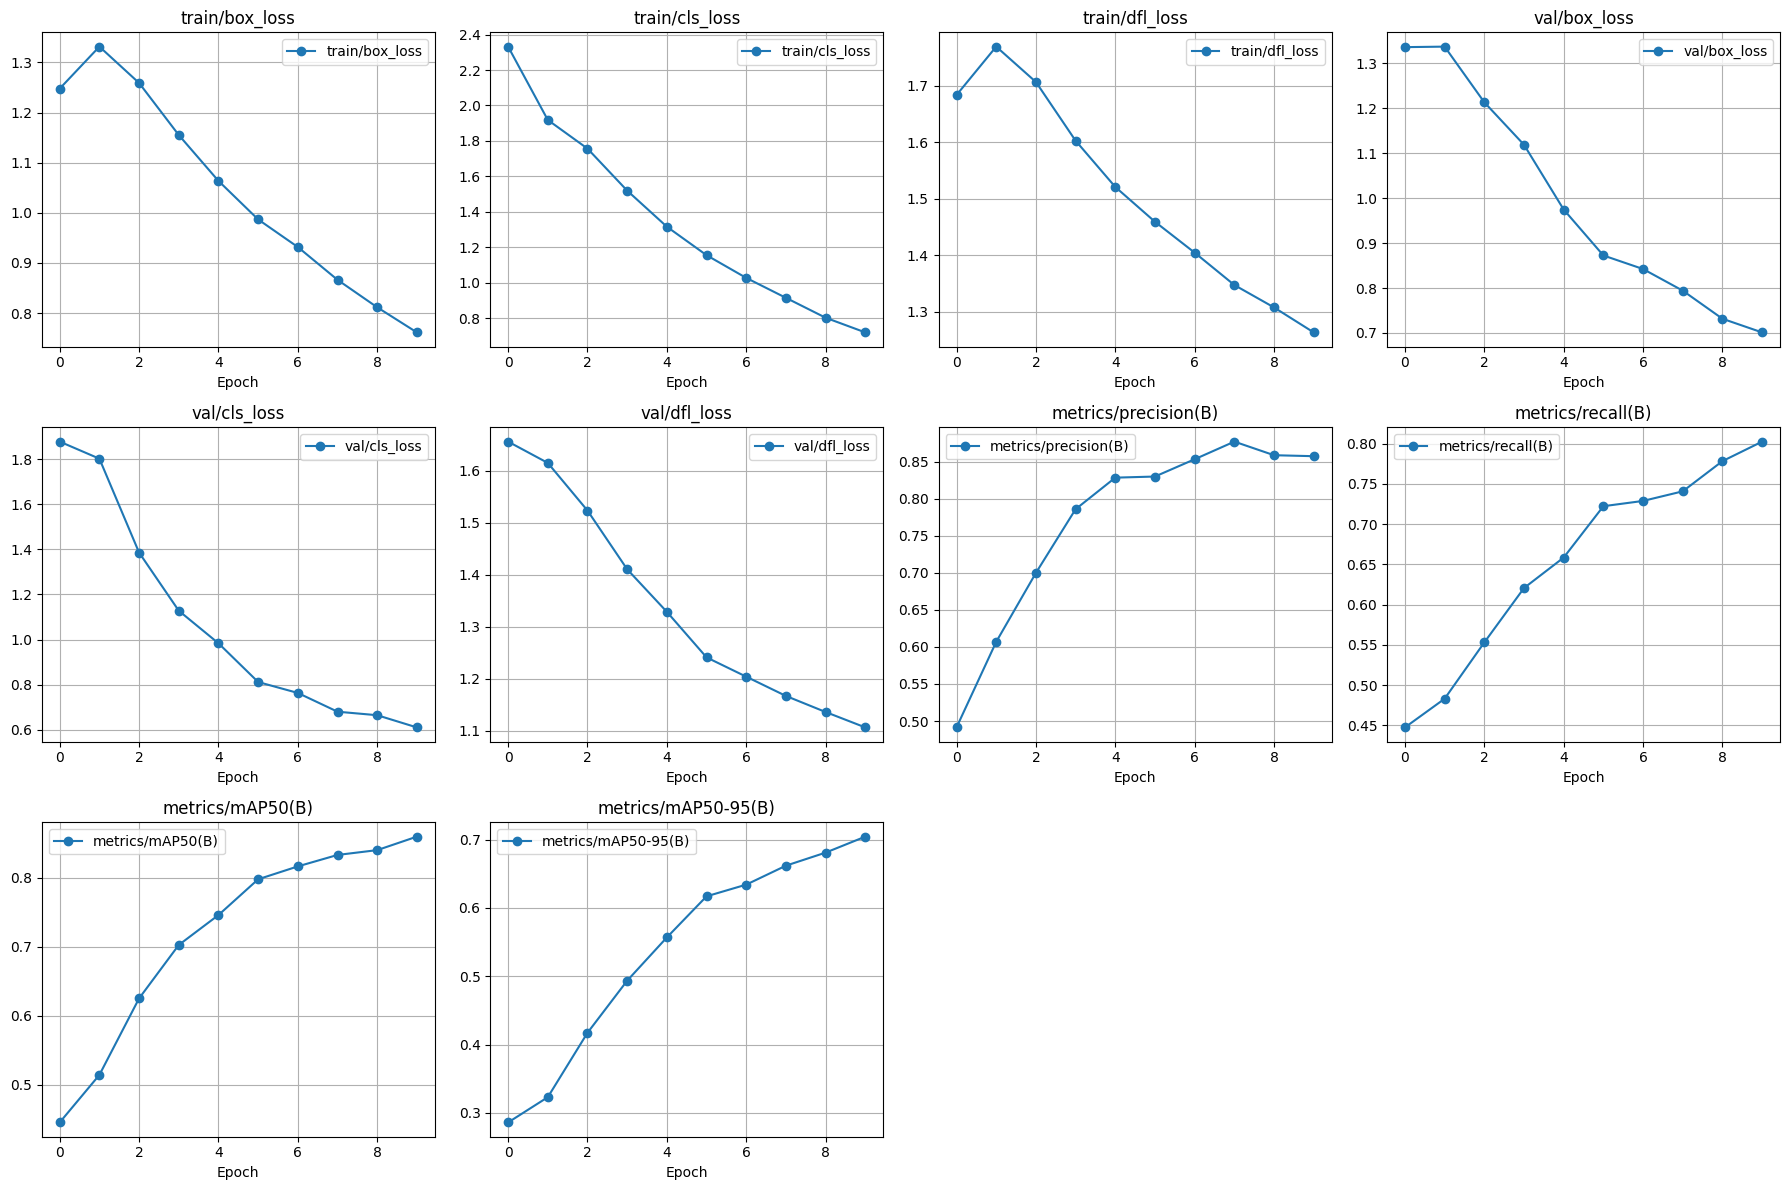

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to results CSV file (change if your path is different)
csv_path = 'runs/detect/train/results.csv'

# Load the CSV file
df = pd.read_csv(csv_path)

# List of metric columns to visualize
metrics = [
    'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
    'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
    'metrics/precision(B)', 'metrics/recall(B)',
    'metrics/mAP50(B)', 'metrics/mAP50-95(B)'
]

# Plot all metrics
plt.figure(figsize=(18, 12))
for i, col in enumerate(metrics):
    plt.subplot(3, 4, i + 1)
    plt.plot(df[col], marker='o', label=col)
    plt.title(col)
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# Print best epoch metrics
best_epoch = df['metrics/mAP50-95(B)'].idxmax()
print(f"Best Epoch: {best_epoch}")
print(df.loc[best_epoch, metrics])


Best Epoch: 9
train/box_loss          0.76143
train/cls_loss          0.71949
train/dfl_loss          1.26359
val/box_loss            0.70117
val/cls_loss            0.61027
val/dfl_loss            1.10620
metrics/precision(B)    0.85749
metrics/recall(B)       0.80240
metrics/mAP50(B)        0.85943
metrics/mAP50-95(B)     0.70433
Name: 9, dtype: float64


## Validate fine-tuned model

In [20]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/my-normal-dataset-1/valid/labels.cache... 1456 images, 0 backgrounds, 0 corrupt: 100% 1456/1456 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/my-normal-dataset-1/valid/images/6350d314dd2e16350d314dd2ed_frame0_jpg.rf.01ebf67009bb985475ebc4553d892d08.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 930, len(boxes) = 2025. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 91/91 [00:19<00:00,  4.57it/s]
                   all       1456       2025      0.858      0.802      0.859      0.704
                 glass      

## Inference with custom model

In [21]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/795 /content/datasets/my-normal-dataset-1/test/images/-15_jpg.rf.efbbbc2113d2c4ed7a3ab8ffb5cb9b79.jpg: 640x640 1 metal, 15.6ms
image 2/795 /content/datasets/my-normal-dataset-1/test/images/-80_jpg.rf.5020d8cc1a103ecebf0c5bfea587c941.jpg: 640x640 1 metal, 15.7ms
image 3/795 /content/datasets/my-normal-dataset-1/test/images/000042_JPG_jpg.rf.e2477bf7aed87df3a999eaf0c33df745.jpg: 640x640 1 paper, 15.6ms
image 4/795 /content/datasets/my-normal-dataset-1/test/images/000085_JPG_jpg.rf.4510037b7229b1ee1f7ca87cc9f8c373.jpg: 640x640 1 paper, 15.6ms
image 5/795 /content/datasets/my-normal-dataset-1/test/images/0008_jpg.rf.1f7a728535d31b0bfb3e2a6889bd5bc9.jpg: 640x640 1 plastic, 15.6ms
image 6/795 /content/datasets/my-normal-dataset-1/test/images/0060_jpg.rf.73968e27595cf70d8c73910cba1cd830.jpg: 640x640 1 plastic, 15.6ms
ima

**NOTE:** Let's take a look at few results.

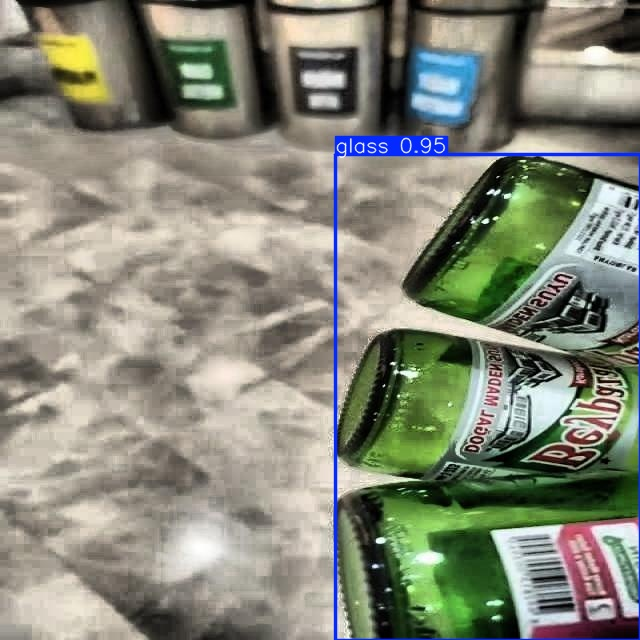

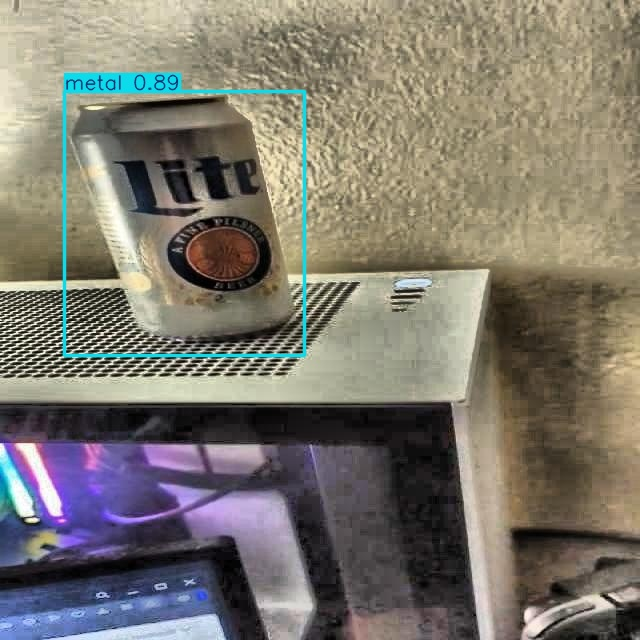

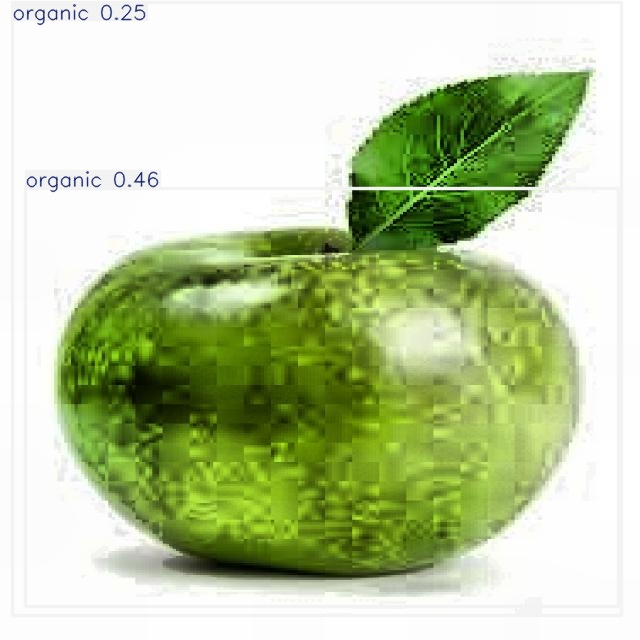

In [22]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")